<a href="https://colab.research.google.com/github/jinkazama45/AI-powered-plant-disease-detection-using-cnn-on-plant-village-dataset-which-is-a-CNN-model-/blob/main/1_0_pytorch_cnn_plant_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STEP 1 Initial Setup: Importing Libraries & Global Constants**




### Step 1: Initial Setup and Data Collection (PyTorch)

This code imports necessary libraries (including PyTorch), mounts Google Drive, defines dataset paths, collects and pairs image and label file paths, sets constants, and splits the data pairs into training, validation, and test sets.

In [ ]:
import os
import numpy as np
import torch # Import PyTorch
from torch.utils.data import Dataset, DataLoader # Import PyTorch data utilities
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms # Often used for image transformations in PyTorch
from PIL import Image # PIL is commonly used for image loading in PyTorch

# --- Google Colab Specific Setup ---
from google.colab import drive
drive.mount('/content/drive')

# --- Dataset Paths ---
# UPDATE this path to where your dataset is located on your Google Drive
base_dataset_path = '/content/drive/MyDrive/erwiam_mendeley_dataset/ERWIAM_dataset_extracted'
image_dir = os.path.join(base_dataset_path, 'Images')
label_dir = os.path.join(base_dataset_path, 'Labels')

# --- Collect Image and Label Paths ---
# Make sure to import `tqdm` if you want the progress bar
# from tqdm import tqdm # Uncomment if you need tqdm here for longer runs

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.lower().endswith('.txt')])

# Create pairs of (image_path, label_path)
data_pairs = []
for img_path in image_files:
    img_name = os.path.basename(img_path).rsplit('.', 1)[0] # Get base name without extension
    label_path = os.path.join(label_dir, img_name + '.txt')
    if os.path.exists(label_path):
        data_pairs.append((img_path, label_path))
    # else:
    #     print(f"WARNING: No label file found for {img_path}. Skipping.") # Uncomment for detailed warnings

print(f"\nFound {len(data_pairs)} initial image-label pairs.")

# --- Filter out pairs with empty or unparseable label files ---
valid_data_pairs = []
all_labels = [] # Recalculate labels from valid pairs
problematic_label_files = []

print("Checking label files for parsing errors...")
for img_path, label_path in data_pairs:
    try:
        with open(label_path, 'r') as f:
            content = f.readline().strip()
            if content:
                # Assuming class ID is the first number on the first line
                class_id = int(content.split(' ')[0])
                # Basic check for non-negative label
                if class_id >= 0:
                     valid_data_pairs.append((img_path, label_path))
                     all_labels.append(class_id)
                else:
                    # Negative labels are not valid class IDs
                     problematic_label_files.append(label_path)
                     # print(f"Warning: Negative class ID found in {label_path}. Skipping.")
            else:
                # Handle empty label file
                problematic_label_files.append(label_path)
                # print(f"Warning: Empty label file {label_path}. Skipping.")

    except (ValueError, IndexError) as e:
        # Handle errors during parsing (e.g., not an integer)
        problematic_label_files.append(label_path)
        # print(f"Warning: Could not parse class ID from {label_path}: {e}. Skipping.")
    except Exception as e:
        # Catch any other file reading errors
        problematic_label_files.append(label_path)
        # print(f"Warning: Error reading {label_path}: {e}. Skipping.")


print(f"Found {len(problematic_label_files)} problematic label files.")
if problematic_label_files:
    print("Skipping samples associated with these label files.")
    # Optional: print problematic files if needed
    # for f in problematic_label_files:
    #     print(f)

data_pairs = valid_data_pairs # Update data_pairs to only include valid ones
print(f"Using {len(data_pairs)} valid image-label pairs after filtering.")


# --- Set Constants ---
IMAGE_SIZE = 256
BATCH_SIZE = 8

if all_labels:
    # Assuming class IDs are 0-indexed and consecutive, or find max ID
    # If not 0-indexed, you might need to map them
    NUM_CLASSES = max(all_labels) + 1
    print(f"Determined number of classes from valid labels: {NUM_CLASSES}")
    # Optional: Verify class distribution from valid labels
    # from collections import Counter
    # print("Class distribution:", Counter(all_labels))
else:
    # Handle case where no valid labels were parsed
    NUM_CLASSES = 5 # Default or based on your knowledge of the dataset
    print(f"Warning: No valid labels were parsed. Using default NUM_CLASSES: {NUM_CLASSES}")
    # If no valid data pairs, subsequent steps will fail gracefully or need checks


# --- Split Data Pairs ---
# Split ratios (e.g., 80% train, 10% validation, 10% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1 # Ensure sum is 1.0

# Ensure there are enough samples to split
if len(data_pairs) > 1:
    # Perform the first split (train vs rest)
    train_pairs, rest_pairs = train_test_split(data_pairs, train_size=train_ratio, random_state=42)

    # Calculate the fraction of rest_pairs that should go into validation
    # Ensure val_ratio + test_ratio > 0
    if (val_ratio + test_ratio) > 0:
        val_size_fraction_of_rest = val_ratio / (val_ratio + test_ratio)
        # Ensure there are enough samples in rest_pairs to split further
        if len(rest_pairs) > 1:
             val_pairs, test_pairs = train_test_split(rest_pairs, train_size=val_size_fraction_of_rest, random_state=42)
        else:
             # Handle case with only one sample left in rest_pairs
             val_pairs = []
             test_pairs = rest_pairs # Put the single sample in test
    else:
        # Handle case where val_ratio and test_ratio are both 0
        val_pairs = []
        test_pairs = []
        # If rest_pairs is not empty, decide where to put them, e.g., add back to train or discard
        if rest_pairs:
             print("Warning: Validation and test ratios are 0, but rest_pairs is not empty. Samples will not be used.")

elif len(data_pairs) == 1:
     # Handle case with only one sample total
     train_pairs = data_pairs
     val_pairs = []
     test_pairs = []
     print("Warning: Only one data sample found. Cannot split into validation/test.")
else:
    # Handle case with no valid data samples
    train_pairs = []
    val_pairs = []
    test_pairs = []
    print("Error: No valid data samples found after filtering. Cannot proceed with splitting.")


print(f"\nTraining samples: {len(train_pairs)}")
print(f"Validation samples: {len(val_pairs)}")
print(f"Test samples: {len(test_pairs)}")
print(f"Total samples after splitting: {len(train_pairs) + len(val_pairs) + len(test_pairs)}") # Should equal len(data_pairs)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Found 1698 initial image-label pairs.
Checking label files for parsing errors...
Found 87 problematic label files.
Skipping samples associated with these label files.
Using 1611 valid image-label pairs after filtering.
Determined number of classes from valid labels: 4

Training samples: 1288
Validation samples: 161
Test samples: 162
Total samples after splitting: 1611


### Step 2: Define Custom PyTorch Dataset

This code defines a custom PyTorch `Dataset` class. This class takes the list of file path pairs (like `train_pairs`) as input and provides a way to load and preprocess individual image-label samples when indexed.

In [ ]:
# Define the custom PyTorch Dataset class
class PlantDiseaseDataset(Dataset):
    def __init__(self, data_pairs, image_size, transform=None):
        """
        Args:
            data_pairs (list): List of tuples (image_path, label_path).
            image_size (int): The target size for resizing images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_pairs = data_pairs
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data_pairs)

    def __getitem__(self, idx):
        # Get the image and label paths for the given index
        image_path, label_path = self.data_pairs[idx]

        # --- Load and Preprocess Image ---
        try:
            # Use PIL to open the image
            image = Image.open(image_path)
            # Convert to RGB to ensure 3 channels
            image = image.convert('RGB')

            # --- Debugging Prints ---
            print(f"\n--- Debugging __getitem__ for {os.path.basename(image_path)} ---")
            print("PIL Image mode after convert('RGB'):", image.mode)
            print("PIL Image size after convert('RGB'):", image.size) # (width, height)
            # --- End Debugging Prints ---

            # Resize image
            image = image.resize((self.image_size, self.image_size))

            # Convert PIL image to PyTorch tensor
            # torchvision.transforms.ToTensor() converts PIL Image (H x W x C) to PyTorch Tensor (C x H x W) and scales to [0, 1]
            image = transforms.ToTensor()(image)

            # --- Debugging Prints ---
            print("PyTorch Tensor shape after ToTensor():", image.shape) # Should be [C, H, W]
            print("PyTorch Tensor dtype after ToTensor():", image.dtype)
            print("--------------------------------------------------------")
            # --- End Debugging Prints ---


        except Exception as e:
            # Handle potential image loading/decoding errors
            print(f"Error loading or processing image {image_path}: {e}")
            # Return dummy data if image loading fails
            # Ensure dummy data has the expected shape and type (C x H x W for PyTorch)
            # Use 3 channels for dummy image to match expected output
            image = torch.zeros(3, self.image_size, self.image_size, dtype=torch.float32) # Dummy black image
            # Use a special label value to indicate an error, or handle this during training/filtering
            label = -1 # Use a special label value for error
            label = torch.tensor(label, dtype=torch.long) # Ensure label is a tensor

            return image, label # Return dummy image and label

        # --- Load and Parse Label ---
        try:
            with open(label_path, 'r') as f:
                # Assuming the first number in the label file is the class ID
                content = f.readline().strip()
                if content:
                    # Assuming class ID is an integer
                    label = int(content.split(' ')[0])
                else:
                    # Handle empty label file
                    print(f"Warning: Empty label file {label_path}")
                    label = -2 # Use a different special value for label parsing error

            # Convert label to PyTorch tensor (long for classification loss)
            label = torch.tensor(label, dtype=torch.long)

        except Exception as e:
            # Handle potential label loading/parsing errors
            print(f"Error loading or parsing label {label_path}: {e}")
            label = -2 # Use a special label value for error
            label = torch.tensor(label, dtype=torch.long) # Ensure it's a tensor

        # Apply optional transformations (e.g., data augmentation)
        if self.transform:
            image = self.transform(image)

        # Return the processed image and label
        return image, label

print("Custom PyTorch Dataset class defined (with debug prints).")

Custom PyTorch Dataset class defined (with debug prints).


### Step 3: Create PyTorch DataLoaders

This code creates instances of the custom `PlantDiseaseDataset` for the training, validation, and test sets and then wraps them in `torch.utils.data.DataLoader` instances. The DataLoaders handle batching, shuffling, and parallel loading of data.

In [ ]:
# Create Dataset instances
train_dataset = PlantDiseaseDataset(data_pairs=train_pairs, image_size=IMAGE_SIZE)
val_dataset = PlantDiseaseDataset(data_pairs=val_pairs, image_size=IMAGE_SIZE)
test_dataset = PlantDiseaseDataset(data_pairs=test_pairs, image_size=IMAGE_SIZE)

# Optional: Define transformations (e.g., data augmentation for training)
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(IMAGE_SIZE),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Example ImageNet normalization
# ])
# test_transform = transforms.Compose([
#     transforms.Resize(int(IMAGE_SIZE*1.14)), # Example common practice for validation/test
#     transforms.CenterCrop(IMAGE_SIZE),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# train_dataset = PlantDiseaseDataset(data_pairs=train_pairs, image_size=IMAGE_SIZE, transform=train_transform)
# val_dataset = PlantDiseaseDataset(data_pairs=val_pairs, image_size=IMAGE_SIZE, transform=test_transform)
# test_dataset = PlantDiseaseDataset(data_pairs=test_pairs, image_size=IMAGE_SIZE, transform=test_transform)


# Create DataLoader instances
# num_workers > 0 enables parallel data loading (recommended)
# Pin_memory=True can speed up data transfer to GPU if using CUDA
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("PyTorch DataLoaders created.")
print(f"Training DataLoader will yield batches of size {BATCH_SIZE}")
print(f"Validation DataLoader will yield batches of size {BATCH_SIZE}")
print(f"Test DataLoader will yield batches of size {BATCH_SIZE}")

# Optional: Inspect one batch from the DataLoader
try:
    print("\nInspecting one batch from the training DataLoader:")
    images, labels = next(iter(train_dataloader))
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Image batch dtype:", images.dtype)
    print("Label batch dtype:", labels.dtype)
    # print("First few labels:", labels[:10]) # Uncomment to see label values
except Exception as e:
     print(f"\nCould not fetch a batch from DataLoader: {e}")

PyTorch DataLoaders created.
Training DataLoader will yield batches of size 8
Validation DataLoader will yield batches of size 8
Test DataLoader will yield batches of size 8

Inspecting one batch from the training DataLoader:

--- Debugging __getitem__ for 20220622_CanonEOS90D_0286_KGH.JPG ---
PIL Image mode after convert('RGB'): RGB
PIL Image size after convert('RGB'): (1280, 1280)

--- Debugging __getitem__ for 20220622_CanonEOS90D_0155_KGH.JPG ---
PIL Image mode after convert('RGB'): RGB
PIL Image size after convert('RGB'): (1280, 1280)
PyTorch Tensor shape after ToTensor(): torch.Size([3, 256, 256])
PyTorch Tensor dtype after ToTensor(): torch.float32
--------------------------------------------------------
PyTorch Tensor shape after ToTensor(): torch.Size([3, 256, 256])
PyTorch Tensor dtype after ToTensor(): torch.float32
--------------------------------------------------------

--- Debugging __getitem__ for 20220622_CanonEOS90D_0040_KGH.JPG ---
PIL Image mode after convert('RGB')

### Step 2: Define Custom PyTorch Dataset

This code defines a custom PyTorch `Dataset` class. This class takes the list of file path pairs (like `train_pairs`) as input and provides a way to load and preprocess individual image-label samples when indexed. It includes error handling for image loading and parsing, returning dummy data if issues occur.

In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import os # Import os for basename in error print

# Define the custom PyTorch Dataset class
class PlantDiseaseDataset(Dataset):
    def __init__(self, data_pairs, image_size, transform=None):
        """
        Args:
            data_pairs (list): List of tuples (image_path, label_path).
            image_size (int): The target size for resizing images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_pairs = data_pairs
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data_pairs)

    def __getitem__(self, idx):
        # Get the image and label paths for the given index
        image_path, label_path = self.data_pairs[idx]

        # --- Load and Preprocess Image ---
        try:
            # Use PIL to open the image
            image = Image.open(image_path)
            # Convert to RGB to ensure 3 channels
            image = image.convert('RGB')

            # --- Debugging Prints ---
            # print(f"\n--- Debugging __getitem__ for {os.path.basename(image_path)} ---")
            # print("PIL Image mode after convert('RGB'):", image.mode)
            # print("PIL Image size after convert('RGB'):", image.size) # (width, height)
            # --- End Debugging Prints ---

            # Resize image
            image = image.resize((self.image_size, self.image_size))

            # Convert PIL image to PyTorch tensor
            # torchvision.transforms.ToTensor() converts PIL Image (H x W x C) to PyTorch Tensor (C x H x W) and scales to [0, 1]
            image = transforms.ToTensor()(image)

            # --- Debugging Prints ---
            # print("PyTorch Tensor shape after ToTensor():", image.shape) # Should be [C, H, W]
            # print("PyTorch Tensor dtype after ToTensor():", image.dtype)
            # print("--------------------------------------------------------")
            # --- End Debugging Prints ---


            # Check if the resulting tensor has 3 channels (H, W might be different before resize if transform is used later)
            # After transforms.ToTensor(), shape should be [C, H, W]
            if image.shape[0] != 3:
                 print(f"Warning: Image {os.path.basename(image_path)} resulted in {image.shape[0]} channels instead of 3 after ToTensor().")
                 # Decide how to handle: return dummy, raise error, etc.
                 # For now, let's proceed but log a warning. If it causes downstream issues, we'll return dummy.
                 # Returning dummy if channel count is wrong
                 print(f"Returning dummy data for image {os.path.basename(image_path)} due to incorrect channel count.")
                 image = torch.zeros(3, self.image_size, self.image_size, dtype=torch.float32) # Dummy black image
                 label = -1 # Use a special label value for error
                 # label = torch.tensor(label, dtype=torch.long) # Ensure label is a tensor - moved below


        except Exception as e:
            # Handle potential image loading/decoding/processing errors
            print(f"Error loading or processing image {image_path}: {e}")
            # Return dummy data if image loading fails
            # Ensure dummy data has the expected shape and type (C x H x W for PyTorch)
            # Use 3 channels for dummy image to match expected output
            image = torch.zeros(3, self.image_size, self.image_size, dtype=torch.float32) # Dummy black image
            # Use a special label value to indicate an error, or handle this during training/filtering
            label = -1 # Use a special label value for error
            # label = torch.tensor(label, dtype=torch.long) # Ensure label is a tensor - moved below


            # Return dummy image and label (label tensor conversion happens below)
            # Continue to label loading/parsing block to ensure label tensor creation and dtype check
            pass # Continue to the label processing block


        # --- Load and Parse Label ---
        # This block is reached for both successful image load and image load errors
        # Need to ensure 'label' variable is set correctly if image loading failed
        if 'label' not in locals() or label == -1:
             # If image loading failed or returned dummy label -1, load/parse label from file
             try:
                with open(label_path, 'r') as f:
                    # Assuming the first number in the label file is the class ID
                    content = f.readline().strip()
                    if content:
                        # Assuming class ID is an integer
                        label = int(content.split(' ')[0])
                    else:
                        # Handle empty label file
                        print(f"Warning: Empty label file {label_path}")
                        label = -2 # Use a different special value for label parsing error

             except Exception as e:
                # Handle potential label loading/parsing errors
                print(f"Error loading or parsing label {label_path}: {e}")
                label = -2 # Use a special label value for error


        # Convert label to PyTorch tensor (long for classification loss)
        label = torch.tensor(label, dtype=torch.long)

        # --- Debugging Print ---
        print(f"Label dtype before return for {os.path.basename(image_path)}:", label.dtype)
        # --- End Debugging Print ---


        # Apply optional transformations (e.g., data augmentation) - applied after ToTensor()
        if self.transform:
            image = self.transform(image)


        # Return the processed image and label
        return image, label

print("Custom PyTorch Dataset class defined (with label dtype debug print).")

Custom PyTorch Dataset class defined (with label dtype debug print).


### Step 3: Create PyTorch DataLoaders

This code creates instances of the custom `PlantDiseaseDataset` for the training, validation, and test sets and then wraps them in `torch.utils.data.DataLoader` instances. The DataLoaders handle batching, shuffling, and parallel loading of data. It also includes an optional section for defining and applying data augmentation transforms.

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Optional: Define transformations (e.g., data augmentation for training)
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(IMAGE_SIZE),
#     transforms.RandomHorizontalFlip(),
#     # No ToTensor() or Normalize() here, they are handled in the Dataset's __getitem__
# ])
# test_transform = transforms.Compose([
#     transforms.Resize(int(IMAGE_SIZE*1.14)), # Example common practice for validation/test
#     transforms.CenterCrop(IMAGE_SIZE),
#     # No ToTensor() or Normalize() here
# ])


# Create Dataset instances
# Pass the transformation pipeline if defined
train_dataset = PlantDiseaseDataset(data_pairs=train_pairs, image_size=IMAGE_SIZE, transform=None) # Use train_transform if defined
val_dataset = PlantDiseaseDataset(data_pairs=val_pairs, image_size=IMAGE_SIZE, transform=None) # Use test_transform if defined
test_dataset = PlantDiseaseDataset(data_pairs=test_pairs, image_size=IMAGE_SIZE, transform=None) # Use test_transform if defined


# Create DataLoader instances
# num_workers > 0 enables parallel data loading (recommended)
# Pin_memory=True can speed up data transfer to GPU if using CUDA
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


print("PyTorch DataLoaders created.")
print(f"Training DataLoader will yield batches of size {BATCH_SIZE}")
print(f"Validation DataLoader will yield batches of size {BATCH_SIZE}")
print(f"Test DataLoader will yield batches of size {BATCH_SIZE}")

# Optional: Inspect one batch from the DataLoader
try:
    print("\nInspecting one batch from the training DataLoader:")
    images, labels = next(iter(train_dataloader))
    print("Image batch shape:", images.shape) # Should be [B, C, H, W]
    print("Label batch shape:", labels.shape) # Should be [B] for scalar labels
    print("Image batch dtype:", images.dtype) # Should be torch.float32
    print("Label batch dtype:", labels.dtype) # Should be torch.long
    # print("First few labels:", labels[:10]) # Uncomment to see label values
except Exception as e:
     print(f"\nCould not fetch a batch from DataLoader: {e}")
     # Check if any errors were printed by the Dataset's __getitem__ (cell a67e1e3c)
     print("Check the output of the previous cell (Dataset __getitem__ debug prints) for potential loading errors.")

PyTorch DataLoaders created.
Training DataLoader will yield batches of size 8
Validation DataLoader will yield batches of size 8
Test DataLoader will yield batches of size 8

Inspecting one batch from the training DataLoader:
Label dtype before return for 20210526_ID051_CanonEOS70D_KGH.JPG: torch.int64
Label dtype before return for 20220622_CanonEOS90D_0296_KGH.JPG: torch.int64
Label dtype before return for 20220622_CanonEOS90D_0717_KGH.JPG: torch.int64
Label dtype before return for 20220622_Tablet_0179_KGH.JPG: torch.int64
Label dtype before return for 20220622_CanonEOS90D_0614_KGH.JPG: torch.int64
Label dtype before return for 20220622_CanonEOS90D_0647_KGH.JPG: torch.int64
Label dtype before return for 20220622_CanonEOS90D_0149_KGH.JPG: torch.int64
Label dtype before return for 20220622_CanonEOS90D_0688_KGH.JPG: torch.int64
Label dtype before return for 20220622_CanonEOS90D_0949_KGH.JPG: torch.int64
Label dtype before return for 20210609_120511_PhoneA_QLB.JPG: torch.int64Label dtype 

### Step 4: Define PyTorch Model

This code defines a Convolutional Neural Network (CNN) model using PyTorch's `torch.nn` module. The model will take input images with 3 channels (RGB) and produce output scores for each of the `NUM_CLASSES`.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN model
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()
        # Define convolutional layers
        # Input size: [BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE]
        # Corrected layer name: nn.Conv2d (lowercase 'd')
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # Output: [B, 32, H, W]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)     # Output: [B, 32, H/2, W/2]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output: [B, 64, H/2, W/2]
        # After pool: [B, 64, H/4, W/4]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Output: [B, 128, H/4, W/4]
        # After pool: [B, 128, H/8, W/8]

        # Calculate the size of the flattened layer
        # IMAGE_SIZE / 8 (due to 3 pooling layers with kernel_size 2)
        self._to_linear = 128 * (IMAGE_SIZE // 8) * (IMAGE_SIZE // 8)

        # Define fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes) # Output layer

    def forward(self, x):
        # Apply convolutional and pooling layers with ReLU activation
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, self._to_linear) # -1 infers the batch size

        # Apply fully connected layers with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # Output layer (no activation here, often applied in loss function)

        return x

# Instantiate the model
model = PlantDiseaseCNN(num_classes=NUM_CLASSES)

# Print the model architecture
print(model)
print("\nPyTorch model defined.")

PlantDiseaseCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

PyTorch model defined.


### Step 5: Define Loss Function and Optimizer (PyTorch)

This code defines the loss function and optimizer for training the PyTorch model. For multi-class classification with integer labels, `CrossEntropyLoss` is suitable. We'll use the `Adam` optimizer.

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function (Cross-Entropy Loss for classification)
# CrossEntropyLoss combines LogSoftmax and NLLLoss.
# It expects raw scores from the model's output layer and target labels as long integers.
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001) # You can adjust the learning rate

print("Loss function and optimizer defined.")

Loss function and optimizer defined.


### Step 6: Train the Model (PyTorch)

This code implements the training loop for the PyTorch model. It iterates over epochs, and within each epoch, it iterates over batches from the training DataLoader, performs forward pass, calculates loss, performs backward pass, and updates weights. It also includes evaluation on the validation set after each epoch.

Streaming output truncated to the last 5000 lines.
Label dtype before return for 20220622_CanonEOS90D_0243_KGH.JPG: torch.int64
Label dtype before return for 20220622_Tablet_0208_KGH.JPG: torch.int64
Label dtype before return for 20220622_CanonEOS90D_0312_KGH.JPG: torch.int64
Label dtype before return for 20210701_ID_119_2_11-56-55_Tablet_KGH.JPG: torch.int64
Label dtype before return for 20220622_CanonEOS90D_0793_KGH.JPG: torch.int64
Label dtype before return for 20220622_Tablet_0527_KGH.JPG: torch.int64
Label dtype before return for 20220622_CanonEOS90D_0624_KGH.JPG: torch.int64
Label dtype before return for 20220622_CanonEOS90D_0469_KGH.JPG: torch.int64
Label dtype before return for 20210526_ID071_CanonEOS70D_KGH.JPG:Label dtype before return for 20220622_CanonEOS90D_0652_KGH.JPG:  torch.int64torch.int64

Label dtype before return for 20220622_CanonEOS90D_0465_KGH.JPG: torch.int64
Label dtype before return for 20210701_ID_065_1_09-56-06_Tablet_KGH.JPG: torch.int64
Label dtype before

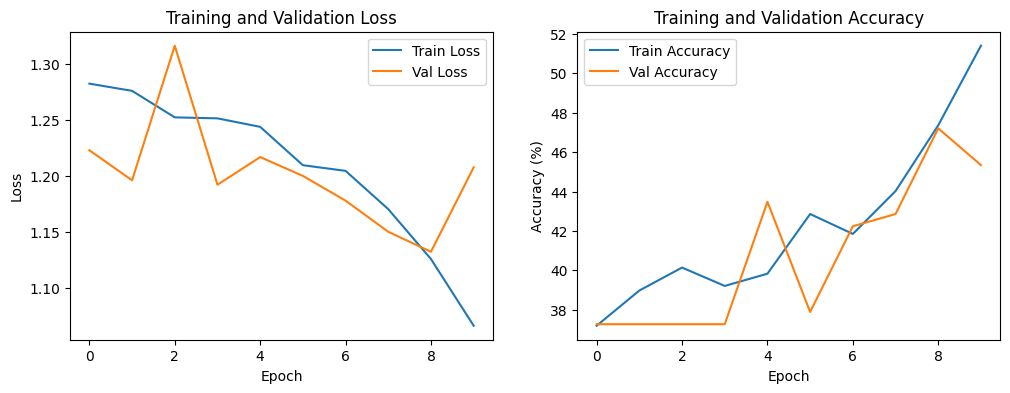

In [ ]:
import torch
import time # To track training time
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the selected device
model.to(device)

# Training loop
num_epochs = 10 # You can adjust the number of epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train() # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_dataloader):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track training loss
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Optional: Print loss and accuracy during epoch
        # if (i + 1) % 10 == 0: # Print every 10 batches
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)


    # --- Validation Phase ---
    model.eval() # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track validation loss
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')

end_time = time.time()
print(f"\nTraining finished in {(end_time - start_time):.2f} seconds.")

# Optional: Plot training history
# Uncommented plotting code
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()